In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
nruns=1
run='hpc_pop_4m'
extra=True
spsp = []
selected_spsp = []
photometry = []
nzs = []
trans_cut = []
trans = []
for i in range(nruns):
    spsp.append(np.load("sps_parameter_samples/sps_"+run+"_"+str(i)+".npy"))
    selected_spsp.append(np.load("sps_parameter_samples/selected_sps_"+run+"_"+str(i)+".npy", allow_pickle=True))
    photometry.append(np.load("photo_samples/photo_"+run+"_"+str(i)+".npy"))
    nzs.append(np.load("nz_samples/nz_"+run+"_"+str(i)+".npy", allow_pickle=True))
    trans_cut.append(np.load("nz_samples/trans_cut_"+run+"_"+str(i)+".npy"))
    trans.append(np.load("nz_samples/trans_"+run+"_"+str(i)+".npy"))

spsp = np.vstack(spsp)
selected_spsp = np.vstack(selected_spsp)
photometry = np.vstack(photometry)
nzs = np.vstack(nzs)
trans_cut = np.vstack(trans_cut)
trans = np.vstack(trans)
print(spsp.shape, selected_spsp.shape, photometry.shape, nzs.shape, trans_cut.shape, trans.shape)

(16, 4000000, 17) (16, 3) (16, 4000000, 5) (16, 3) (16, 3) (16, 3)


In [3]:
nsamples = 1000000
real = 0
tot_m = np.log10(spsp[real, :][:nsamples, -1])
tot_z = spsp[real, :][:nsamples, 0]

7.393939393939394
7.515151515151515
8.181818181818183


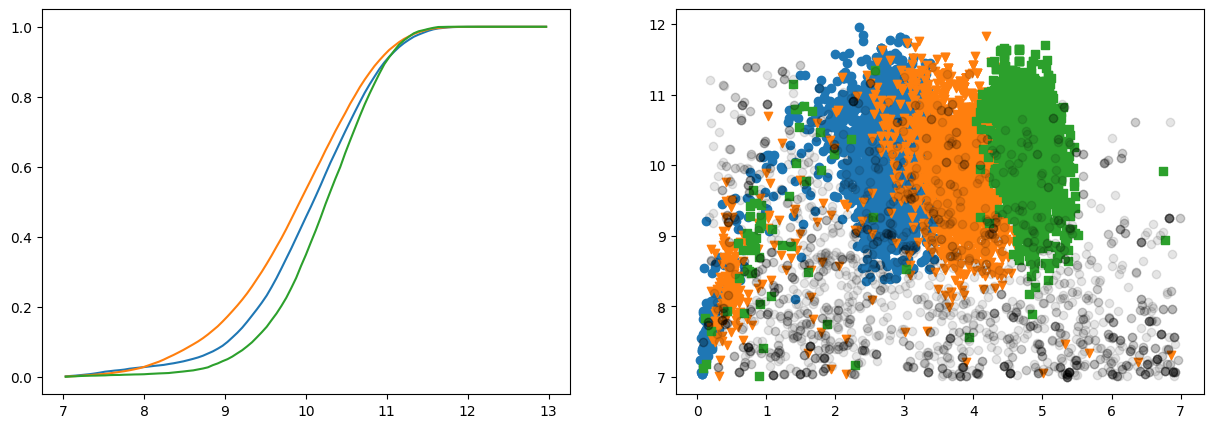

In [4]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))

m_bin = np.linspace(7, 13, 100)
m_bin_mid = (m_bin[:-1] + m_bin[1:])/2

u_sel = np.squeeze(selected_spsp[real, :][0])
u_sel_m = np.log10(u_sel[:, -1])
u_sel_z = u_sel[:, 0]

g_sel = np.squeeze(selected_spsp[real, :][1])
g_sel_m = np.log10(g_sel[:, -1])
g_sel_z = g_sel[:, 0]

r_sel = np.squeeze(selected_spsp[real, :][2])
r_sel_m = np.log10(r_sel[:, -1])
r_sel_z = r_sel[:, 0]

counts_u, _ = np.histogram(u_sel_m, bins=m_bin, density=False)
total_counts_u = u_sel.shape[0]
cumulative_sum_u = np.cumsum(counts_u)/total_counts_u

counts_g, _ = np.histogram(g_sel_m, bins=m_bin, density=False)
total_counts_g = g_sel.shape[0]
cumulative_sum_g = np.cumsum(counts_g)/total_counts_g

counts_r, _ = np.histogram(r_sel_m, bins=m_bin, density=False)
total_counts_r = r_sel.shape[0]
cumulative_sum_r = np.cumsum(counts_r)/total_counts_r

#mlim = 8.0

ax[0].plot(m_bin_mid, cumulative_sum_u)
#ax[0].vlines(mlim, 0, 1, colors='k', ls='--')

ax[0].plot(m_bin_mid, cumulative_sum_g)
#ax[0].vlines(mlim, 0, 1, colors='k', ls='--')

ax[0].plot(m_bin_mid, cumulative_sum_r)
#ax[0].vlines(mlim, 0, 1, colors='k', ls='--')

print(m_bin_mid[np.where(cumulative_sum_u < 0.01)[0][-1]])
print(m_bin_mid[np.where(cumulative_sum_g < 0.01)[0][-1]])
print(m_bin_mid[np.where(cumulative_sum_r < 0.01)[0][-1]])

plot_samples = 2000
ax[1].scatter(u_sel_z[:plot_samples], u_sel_m[:plot_samples], alpha=1.0)
ax[1].scatter(g_sel_z[:plot_samples], g_sel_m[:plot_samples], alpha=1.0, marker='v')
ax[1].scatter(r_sel_z[:plot_samples], r_sel_m[:plot_samples], alpha=1.0, marker='s')
ax[1].scatter(tot_z[:plot_samples], tot_m[:plot_samples], color='k', alpha=0.1)
